In [1]:
__PRODUCTION__ = 0
__NAME__       = 'motivation'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.65

if __PRODUCTION__:
    from mplmagic2 import pgf
else:
    from mplmagic2 import svg

from mplmagic2 import SuperFigure
import matplotlib.pyplot as plt

# print('This is how much space the figure will take up on letter paper')
# SuperFigure.size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [7]:
import dill
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim

from symfac.experimental import RBFExpansionPlus, RBFExpansionMiniBatchPlus

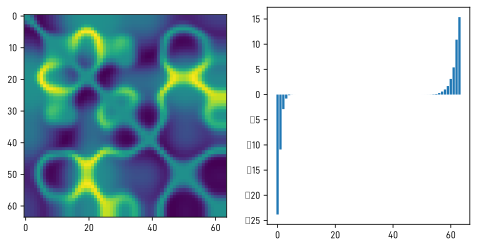

[0.12843, 0.07073, 0.04168, 0.0127, 0.0056, 0.00325, 0.00121, 0.00052, 0.00027]


In [130]:
def rbf(X, Y=None):
    return np.exp(-np.subtract.outer(X, Y if Y is not None else X)**2)

n = 64

np.random.seed(128)
u = 5 * np.random.randn(n)
v = 4 * np.random.randn(n)
w = 5 * np.random.randn(n)
u = gaussian_filter1d(u, 3., order=0)
v = gaussian_filter1d(v, 6., order=0)
w = gaussian_filter1d(w, 4., order=0)
# u = np.array([
#     -2.8422842 , -2.59959471, -2.14253788, -1.5301923 , -0.84786886,
#     -0.19238268,  0.3535188 ,  0.7451126 ,  0.98769341,  1.12728921,
#     1.22123126,  1.30677826,  1.37676732,  1.38389267,  1.26954621,
#     1.00343335,  0.61256407,  0.17992431, -0.18035911, -0.36412001,
#     -0.31161398, -0.02391593,  0.43754659,  0.96979312,  1.45582367,
#     1.79752477,  1.94453304,  1.90738196,  1.74876882,  1.55577609,
#     1.40769611,  1.35717703,  1.42515953,  1.60967334,  1.89612485,
#     2.259902  ,  2.66149509,  3.04047122,  3.31724775,  3.4108758 ,
#     3.26763474,  2.88493444,  2.31598506,  1.6507696 ,  0.98454662,
#     0.38971481, -0.09512454, -0.45891063, -0.70563618, -0.84245001,
#     -0.87505707, -0.80934931, -0.65229457, -0.41168359, -0.09460715,
#     0.28737368,  0.7093422 ,  1.12925013,  1.49624781,  1.77002085,
#     1.93653771,  2.01217823,  2.0318691 ,  2.03111968
# ])
# v = np.array([
#     -1.90751554, -1.88753505, -1.84899046, -1.79372897, -1.72451378,
#     -1.64359633, -1.55289825, -1.45352298, -1.34536103, -1.22739335,
#     -1.09840247, -0.95662366, -0.80189506, -0.63502305, -0.4592951 ,
#     -0.27935404, -0.1027287 ,  0.0622785 ,  0.20661623,  0.32175542,
#     0.40088196,  0.43909793,  0.43473558,  0.38948207,  0.30834798,
#     0.1988298 ,  0.07059114, -0.06628259, -0.20130572, -0.32565458,
#     -0.43209635, -0.51637295, -0.57690602, -0.61523717, -0.6351884 ,
#     -0.64276645, -0.64446682, -0.64768775, -0.65890547, -0.68357236,
#     -0.72492315, -0.78420619, -0.86024822, -0.94962877, -1.04729341,
#     -1.14674739, -1.2411986 , -1.32413593, -1.39014532, -1.43584497,
#     -1.45986043, -1.46281729, -1.44779205, -1.41887775, -1.38161552,
#     -1.34095427, -1.30175817, -1.26721601, -1.23939102, -1.218721  ,
#     -1.20519998, -1.19697692, -1.19267507, -1.19092109
# ])


K = rbf(u) - rbf(v)
Kt = torch.tensor(K, dtype=torch.float32)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(K)
axs[1].bar(np.arange(n), np.linalg.eigvalsh(K))
plt.show()

U, S, V = np.linalg.svd(K)
svd_K = []
for k in range(1, 10):
    truncation = (U[:, :k] * S[None, :k]) @ V[:k, :]
    svd_K.append(round(float(F.mse_loss(torch.tensor(truncation), torch.tensor(K))), 5))
print(svd_K)

In [131]:
print(repr(u))
print(repr(v))

array([-2.8422842 , -2.59959471, -2.14253788, -1.5301923 , -0.84786886,
       -0.19238268,  0.3535188 ,  0.7451126 ,  0.98769341,  1.12728921,
        1.22123126,  1.30677826,  1.37676732,  1.38389267,  1.26954621,
        1.00343335,  0.61256407,  0.17992431, -0.18035911, -0.36412001,
       -0.31161398, -0.02391593,  0.43754659,  0.96979312,  1.45582367,
        1.79752477,  1.94453304,  1.90738196,  1.74876882,  1.55577609,
        1.40769611,  1.35717703,  1.42515953,  1.60967334,  1.89612485,
        2.259902  ,  2.66149509,  3.04047122,  3.31724775,  3.4108758 ,
        3.26763474,  2.88493444,  2.31598506,  1.6507696 ,  0.98454662,
        0.38971481, -0.09512454, -0.45891063, -0.70563618, -0.84245001,
       -0.87505707, -0.80934931, -0.65229457, -0.41168359, -0.09460715,
        0.28737368,  0.7093422 ,  1.12925013,  1.49624781,  1.77002085,
        1.93653771,  2.01217823,  2.0318691 ,  2.03111968])
array([-1.90751554, -1.88753505, -1.84899046, -1.79372897, -1.72451378,
    

In [132]:
'''
This one is learnable

array([-0.61852069, -0.70566253, -0.88404148, -1.15892152, -1.52824981,
       -1.97468162, -2.45724627, -2.91086763, -3.25520082, -3.41426062,
       -3.33868049, -3.02083685, -2.49295455, -1.81451568, -1.0514998 ,
       -0.26373814,  0.50152485,  1.20712816,  1.8185296 ,  2.29631324,
        2.5920093 ,  2.65728349,  2.46393546,  2.03070788,  1.43661464,
        0.80729447,  0.26968021, -0.10080012, -0.30936562, -0.42661647,
       -0.53920191, -0.69849308, -0.89663988, -1.07597983, -1.15934644,
       -1.08511663, -0.83424122, -0.44297154,  0.00555435,  0.40412054,
        0.65525203,  0.69251576,  0.4900412 ,  0.06549663, -0.51954941,
       -1.16443594, -1.75153178, -2.18310077, -2.41353145, -2.45715919,
       -2.36334641, -2.17866021, -1.92304569, -1.59413434, -1.19162237,
       -0.74080297, -0.29745649,  0.07290833,  0.32396427,  0.45106385,
        0.48734459,  0.48055966,  0.46674246,  0.45933873])
array([ 0.35345947,  0.32852344,  0.28108044,  0.21584186,  0.13866338,
        0.05619471, -0.02497069, -0.10013849, -0.16648167, -0.22385049,
       -0.27495926, -0.32494978, -0.38106934, -0.45026396, -0.53923942,
       -0.65240106, -0.79095305, -0.95290619, -1.13287658, -1.32313016,
       -1.51381012, -1.69492792, -1.85725026, -1.99304195, -2.09639785,
       -2.16398518, -2.19402509, -2.18710246, -2.14437193, -2.06812665,
       -1.96119719, -1.82643165, -1.6675798 , -1.48919851, -1.29654709,
       -1.09601101, -0.89497676, -0.70163205, -0.52433234, -0.37164924,
       -0.25123231, -0.16970068, -0.13193977, -0.14059893, -0.19561591,
       -0.29372749, -0.42873357, -0.59113403, -0.76884866, -0.94780026,
       -1.11298258, -1.24994904, -1.34624678, -1.39242497, -1.38421977,
       -1.32195702, -1.21136896, -1.06277743, -0.89054058, -0.71112517,
       -0.54163944, -0.39804912, -0.29422724, -0.23972729])
''';

In [133]:
torch.manual_seed(15513512)

K = rbf(u) - rbf(v)  # + rbf(w)

fac = RBFExpansionPlus(
    k=3,
    batch_size=512,
    # lr=0.1,
    max_steps=8192 + 1,
    # algorithm=lambda x, lr: torch.optim.Adam(x, lr=lr),  #, eps=1e-6, betas=(0.9, 0.9)),
    # loss=lambda output, target, reduction=None: F.mse_loss(output, target, reduction='none')
)

component_history = []

def component_history_callback(step, model):
    if step == 0 or 4**int(np.log2(step) / 2) == step:
        component_history.append(dict(
            step=step,
            model=dill.loads(dill.dumps(model))
        ))

fac.fith(
    K.astype(np.float32),
    plugins=[
        dict(
            every=1,
            requires=['step', 'model'],
            callback=component_history_callback
        )
    ],
    u0=0.1 * torch.randn(fac.batch_size, n, fac.k),
    a0=torch.randn(fac.batch_size, fac.k),
    b0=torch.randn(fac.batch_size),
)

100%|██████████| 8193/8193 [00:29<00:00, 278.50it/s]


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


tensor([ 0.9892, -1.0060,  1.3165], device='cuda:0')


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


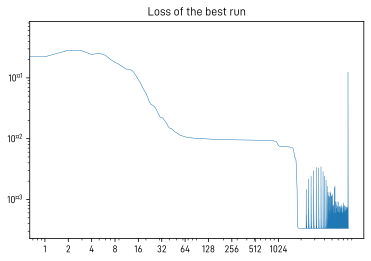

/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:90: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/symfac/.local/lib/python3.8/site-packages/matplotlib/textpath.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


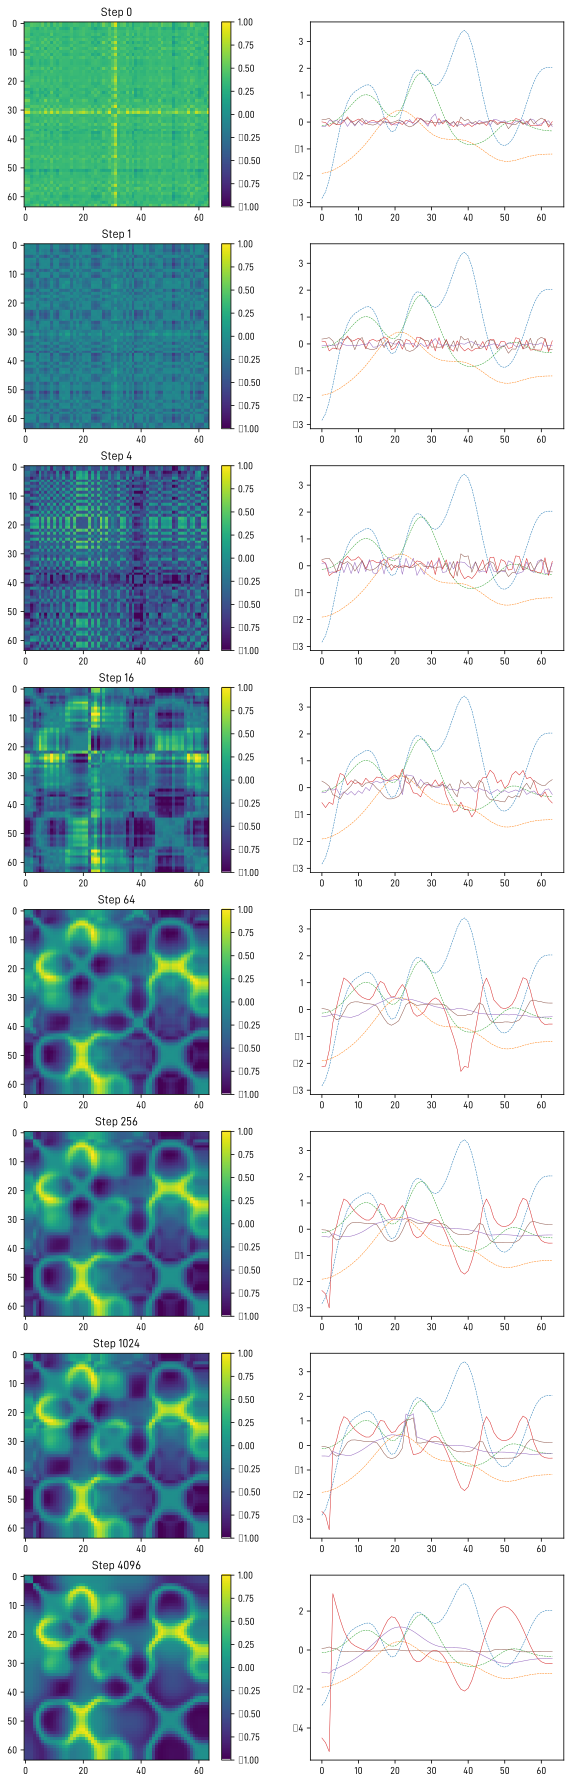

In [134]:
best_run = np.argmin(fac.report.loss_best)

print(fac.optimum.a[best_run, :])

plt.plot(fac.report.loss_history_ticks, fac.report.loss_history[:, best_run])
plt.xscale('log')
plt.yscale('log')
xticks = 2**np.arange(11)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks)
plt.title('Loss of the best run')
plt.show()

fig, axs = plt.subplots(len(component_history), 2, figsize=(10, 4 * len(component_history)))

for snapshot, axrow in zip(component_history, axs):
    step = snapshot['step']
    model = snapshot['model']
    axrow[0].set_title(f'Step {step}')
    im = axrow[0].imshow(
        model(runs=best_run, device='cpu', grad_on=False),
        vmin=-1, vmax=1
    )
    plt.colorbar(mappable=im, ax=axrow[0])
    axrow[1].plot(u, ls='dashed')
    axrow[1].plot(v, ls='dashed')
    axrow[1].plot(w, ls='dashed')
    axrow[1].plot(model.u[best_run, :, 0].detach().cpu())
    axrow[1].plot(model.u[best_run, :, 1].detach().cpu())
    axrow[1].plot(model.u[best_run, :, 2].detach().cpu())

plt.show()

In [127]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3.5))

axs = axs.reshape(2, 2)

best_run = np.argmin(fac.report.loss_best)


axs[0, 0].plot(fac.report.loss_history_ticks, fac.report.loss_history)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')

axs[0, 1].imshow(fac.optimum(runs=best_run))

axs[1, 0].plot(u)
axs[1, 0].plot(v)
for i in range(fac.k):
        axs[1, 1].plot(fac.optimum.u[best_run, :, i].detach().cpu())
axs[1, 1].plot(u, '--')
axs[1, 1].plot(v, '--')

for ax in axs[1]:
    ax.set_ylim([-4, 4])

plt.show()

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

# SGD

In [ ]:
facX = RBFExpansionMiniBatchPlus(
    k=2,
    mini_batch_size=2 * 8,
    batch_size=256,
    lr=0.0001,
    algorithm='Adam',
    max_steps=1000000,
)

facX.fit_custom(
    K.astype(np.float32),
    f=lambda rbf, u, a, b: torch.sum(
        rbf(u[..., :, None, :] - u[..., None, :, :]) *
        a[..., None, None, :],
        dim=-1
    ) + b[..., None, None],
    f_minibatch=lambda rbf, i, j, u, a, b: torch.sum(
        rbf(u[..., i, :] - u[..., j, :]) *
        a[..., None, :],
        dim=-1
    ) + b[..., None],
    u=0.1 * torch.rand(facX.batch_size, n, facX.k),
    a=torch.randn(facX.batch_size, facX.k),
    b=torch.randn(facX.batch_size),
    seed=1234,
)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3.5))

axs = axs.reshape(2, 2)

best_run = np.argmin(facX.report.loss_best)


axs[0, 0].plot(facX.report.loss_history_ticks, facX.report.loss_history)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')

axs[0, 1].imshow(facX.optimum(runs=best_run))

axs[1, 0].plot(u)
axs[1, 0].plot(v)
axs[1, 1].plot(facX.optimum.u[best_run, :, 0].detach().cpu())
axs[1, 1].plot(facX.optimum.u[best_run, :, 1].detach().cpu())
axs[1, 1].plot(u)
axs[1, 1].plot(v)

for ax in axs[1]:
    ax.set_ylim([-4, 4])

plt.show()